In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
seed(1)

import pandas as pd

import tensorflow
tensorflow.random.set_seed(1)
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import load_model, save_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

2022-01-08 14:15:46.344638: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-08 14:15:46.344680: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


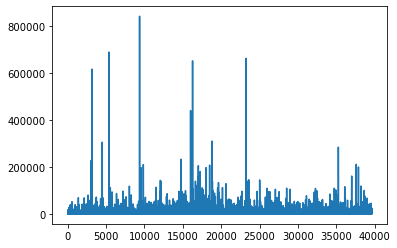

In [2]:
df = pd.read_csv('data/OnlineNewsPopularity.csv', header=0)
plt.plot(df['shares'])
plt.savefig('images/shares.jpg')

In [3]:
# Dropping non-predictive attributes
df.drop(['url', 'timedelta'], axis='columns', inplace=True)

In [6]:
# Classifying popular posts
med = df['shares'].median()
df['is_popular'] = df.apply(lambda row: 1 if row.shares > med else 0, axis=1)
df['is_popular'].value_counts()

0    20082
1    19562
Name: is_popular, dtype: int64

In [7]:
# Splitting the dataset into training and test sets
X = df.drop(['is_popular', 'shares'], axis='columns')
y = df[['is_popular']]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [8]:
# Scaling numerical features
y_train=np.reshape(y_train, (-1,1))
y_val=np.reshape(y_val, (-1,1))

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

print(scaler_x.fit(X_train))
xtrain_scale = scaler_x.transform(X_train)

print(scaler_x.fit(X_val))
xval_scale = scaler_x.transform(X_val)

print(scaler_y.fit(y_train))
ytrain_scale = scaler_y.transform(y_train)

print(scaler_y.fit(y_val))
yval_scale = scaler_y.transform(y_val)

MinMaxScaler()
MinMaxScaler()
MinMaxScaler()
MinMaxScaler()


In [22]:
# Model architecture
# (default hidden_layer_units=30, optimizer=adam)
def create_model(neurons=30, optimizer='adam', init_mode='uniform'):
    model = Sequential()
    model.add(Dense(58, input_dim=58, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(30, activation='relu', kernel_initializer=init_mode))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=init_mode))
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) 
    return model

# Graph accuracy per epoch
def graph_acc(history, img_name='model', save=False, model=None):

    # Accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    if(save==True):
        assert model
        plt.savefig(f"images/{img_name}.jpg")
        save_model(model, f"{img_name}.h5", overwrite=True, include_optimizer=True)

    plt.show()

# Verify model.evaluate() accuracy score and compute precision, recall, and f1
def score(model):
    
    # Evaluate model accuracy using model.evaluate()
    pred_train = model.predict(xtrain_scale)
    scores = model.evaluate(xtrain_scale, ytrain_scale, verbose=0)
    print(f"Accuracy on training data: {scores[1]}\nError on training data: {1-scores[1]}\n")   
 
    pred_test = model.predict(xval_scale)
    scores2 = model.evaluate(xval_scale, yval_scale, verbose=0)
    print(f"Accuracy on testing data: {scores2[1]}\nError on testing data: {1-scores2[1]}\n")   

    # Compute for accuracy, precision, recall, f1
    y_predicted = model.predict(xval_scale) > 0.5
    tn, fp, fn, tp = confusion_matrix(yval_scale, y_predicted).ravel()

    accuracy = (tp+tn)/(tn+fp+fn+tp)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))

    print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-score: {f1}")

In [11]:
# Training the original model
model = create_model()
history = model.fit(xtrain_scale, ytrain_scale, epochs=100, validation_split=0.25)

2022-01-08 10:25:43.484330: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-08 10:25:43.484379: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-08 10:25:43.484408: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2022-01-08 10:25:43.484722: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
744/744 [==============================] - 2s 2ms/step - loss: 0.6536 - accuracy: 0.6147 - val_loss: 0.6422 - val_accuracy: 0.6355
Epoch 2/100
744/744 [==============================] - 1s 2ms/step - loss: 0.6421 - accuracy: 0.6336 - val_loss: 0.6383 - val_accuracy: 0.6385
Epoch 3/100
744/744 [==============================] - 1s 2ms/step - loss: 0.6390 - accuracy: 0.6373 - val_loss: 0.6370 - val_accuracy: 0.6436
Epoch 4/100
744/744 [==============================] - 1s 2ms/step - loss: 0.6372 - accuracy: 0.6377 - val_loss: 0.6327 - val_accuracy: 0.6442
Epoch 5/100
744/744 [==============================] - 1s 2ms/step - loss: 0.6346 - accuracy: 0.6425 - val_loss: 0.6317 - val_accuracy: 0.6508
Epoch 6/100
744/744 [==============================] - 1s 2ms/step - loss: 0.6329 - accuracy: 0.6418 - val_loss: 0.6291 - val_accuracy: 0.6508
Epoch 7/100
744/744 [==============================] - 1s 2ms/step - loss: 0.6319 - accuracy: 0.6434 - val_loss: 0.6385 - val_accuracy: 0.6436

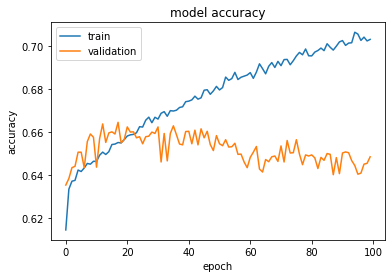

Accuracy on training data: 0.6960744261741638
Error on training data: 0.3039255738258362

Accuracy on testing data: 0.6145793795585632
Error on testing data: 0.38542062044143677

Accuracy: 0.6145793921049313
Precision: 0.5747526566507878
Recall: 0.8101756198347108
F1-score: 0.6724544480171489


In [23]:
graph_acc(history, 'og-model', save=True, model=model)
score(model)

# Hyperparameter Tuning using GridSearchCV

In [ ]:
hyper_model = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)

# Hyperparameters and specified values
neurons = [5, 10, 15, 20, 25, 30]
epochs = [25, 50, 100, 250, 500]                      
optimizer = ['sgd', 'adam', 'rmsprop']

param_grid = dict(
    neurons = neurons,
    epochs = epochs,
    optimizer = optimizer
)

grid = GridSearchCV(estimator=hyper_model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(xtrain_scale, ytrain_scale)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fewer hidden layer units and number of epochs == better?
SGD option for optimizing dropped since it consistently performs lower at fewer epochs than adam, rmsprop

In [ ]:
# Round 2
hyper_model = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)

neurons = [1, 2, 3, 4, 5]
epochs = [20, 21, 22, 23, 24, 25]
optimizer = ['adam', 'rmsprop']

param_grid = dict(
    neurons = neurons,
    epochs = epochs,
    optimizer = optimizer
)

grid = GridSearchCV(estimator=hyper_model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(xtrain_scale, ytrain_scale)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [13]:
# Training the tuned model
tuned_model = create_model(optimizer='rmsprop', neurons=5)
tuned_history = tuned_model.fit(xtrain_scale, ytrain_scale, epochs=24, validation_split=0.25)

Epoch 1/24
744/744 [==============================] - 2s 2ms/step - loss: 0.6547 - accuracy: 0.6132 - val_loss: 0.6405 - val_accuracy: 0.6369
Epoch 2/24
744/744 [==============================] - 1s 2ms/step - loss: 0.6433 - accuracy: 0.6326 - val_loss: 0.6405 - val_accuracy: 0.6370
Epoch 3/24
744/744 [==============================] - 1s 2ms/step - loss: 0.6408 - accuracy: 0.6374 - val_loss: 0.6360 - val_accuracy: 0.6382
Epoch 4/24
744/744 [==============================] - 1s 2ms/step - loss: 0.6383 - accuracy: 0.6368 - val_loss: 0.6344 - val_accuracy: 0.6477
Epoch 5/24
744/744 [==============================] - 1s 2ms/step - loss: 0.6361 - accuracy: 0.6400 - val_loss: 0.6317 - val_accuracy: 0.6452
Epoch 6/24
744/744 [==============================] - 1s 2ms/step - loss: 0.6346 - accuracy: 0.6420 - val_loss: 0.6302 - val_accuracy: 0.6519
Epoch 7/24
744/744 [==============================] - 1s 2ms/step - loss: 0.6323 - accuracy: 0.6444 - val_loss: 0.6426 - val_accuracy: 0.6447
Epoch 

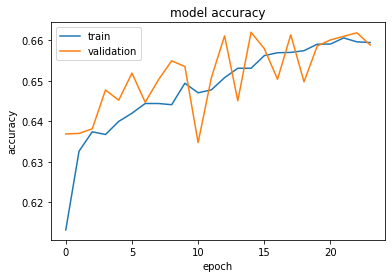

Accuracy on training data: 0.665205717086792
Error on training data: 0.334794282913208

Accuracy on testing data: 0.610795795917511
Error on testing data: 0.389204204082489

Accuracy: 0.6107958128389457
Precision: 0.566723259762309
Recall: 0.8620867768595041
F1-score: 0.6838762548658062


In [24]:
# Graph accuracy of tuned model and evaluate
graph_acc(tuned_history, 'tuned-model', save=True, model=tuned_model)

# Validate model accuracy and evaluate precision, recall, f1
score(tuned_model)

In [3]:
np.set_printoptions(threshold=np.inf)

model = load_model('og-model.h5')
weights = model.get_weights()
print(weights)

2022-01-08 14:17:36.229082: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-08 14:17:36.229124: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-08 14:17:36.229157: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2022-01-08 14:17:36.229440: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[array([[-7.48971477e-02,  1.84575930e-01, -1.21592404e-02,
         1.46326020e-01, -2.81926896e-02, -1.46732386e-02,
        -2.34849919e-02,  4.36757177e-01,  1.94812924e-01,
        -8.74374341e-03, -7.97862649e-01,  5.33781992e-03,
        -1.88596249e-01,  1.27761699e-02, -3.84582639e-01,
        -3.66873145e-01, -3.49666387e-01,  6.78369775e-02,
        -1.60586596e-01,  1.79459170e-01, -1.79930463e-01,
        -1.08745031e-01,  2.48695016e-01, -2.77280837e-01,
        -3.83170754e-01,  2.54722070e-02, -1.73404086e-02,
        -2.57614851e-02,  1.74557760e-01,  1.10511020e-01,
         5.55164590e-02, -4.82836701e-02, -1.15130488e-02,
        -1.43554702e-01, -3.36516529e-01,  1.47519976e-01,
        -6.61825910e-02,  2.77490467e-01,  2.09552363e-01,
        -2.54905224e-01,  8.01519770e-03, -5.25505207e-02,
        -1.86924357e-02, -5.91389053e-02,  4.19142283e-02,
         2.62079060e-01, -1.69160336e-01,  4.56897676e-01,
         1.60213009e-01, -2.36513112e-02,  6.15569651e-

In [4]:
model = load_model('tuned-model.h5')
weights = model.get_weights()

print(weights)

[array([[-6.31766245e-02, -4.03185859e-02, -1.41598182e-02,
        -8.26986358e-02, -3.91565450e-02, -5.61047457e-02,
        -2.66193021e-02, -1.06926332e-03, -5.41744009e-02,
        -5.95566742e-02, -1.67855769e-01, -1.04822956e-01,
        -5.01402617e-02, -1.17350698e-01, -4.42113504e-02,
         3.36888358e-02, -6.50427490e-02,  4.32569385e-02,
        -7.43059888e-02, -1.01292908e-01, -1.38584077e-01,
        -9.94481668e-02, -1.18213043e-01, -1.11326436e-02,
        -8.98237973e-02, -1.45074800e-01, -1.53741362e-02,
         6.69230223e-02,  8.84863362e-03, -5.43951727e-02,
        -2.32096035e-02, -4.26412784e-02, -1.39847361e-02,
         2.60120966e-02,  2.39409897e-02, -3.45034041e-02,
        -9.53639224e-02, -3.65507975e-02, -3.15080732e-02,
        -5.36913425e-02, -1.77412406e-02, -8.79875049e-02,
         5.59590869e-02, -1.88588336e-01, -1.03534676e-01,
        -1.83489416e-02, -1.34380274e-02, -4.78888042e-02,
         3.35395671e-02, -1.10355234e-02, -5.66041730e-